In [14]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit as tt
import geopandas as gpd
import geoplot as gp
from shapely.geometry import Point
from shapely.geometry import Polygon
import pickle
from scipy.spatial.distance import squareform

## Import data

In [4]:
# set path
path = 'C:\\Users\\Dom\\Documents\\NoteBooks\\Blog Stuff\\Spoons TSP\\'

# import data and merge 
uk_counties_gdf = gpd.read_file(path + 'shapefiles\\Counties_and_Unitary_Authorities_December_2017_Full_Extent_Boundaries_in_UK_WGS84.shp')
uk_postcodes_df = pd.read_csv(path + 'ukpostcodes.csv')
spoons_location_df = pd.read_excel(path + 'Spoons Names and Addresses.xlsx')
spoons_location_full_df = pd.merge(spoons_location_df, uk_postcodes_df, left_on='Postcode', right_on='postcode')

# turn into geodataframe
geometry = [Point(xy) for xy in zip(spoons_location_full_df.longitude, spoons_location_full_df.latitude)]
crs = {'init': 'epsg:4326'}
spoons_location_full_df = gpd.GeoDataFrame(spoons_location_full_df, crs=crs, geometry=geometry)
spoons_location_london_df = spoons_location_full_df[spoons_location_full_df['County'] == 'London']

# define london boroughs and put in geodataframe
london_boroughs = ['Barking and Dagenham','Barnet','Bexley','Brent','Bromley','Camden','City of London','Croydon','Ealing','Enfield','Greenwich','Hackney','Hammersmith and Fulham','Haringey','Harrow','Havering','Hillingdon','Hounslow','Islington','Kensington and Chelsea','Kingston upon Thames','Lambeth','Lewisham','Merton','Newham','Redbridge','Richmond upon Thames','Southwark','Sutton','Tower Hamlets','Waltham Forest','Wandsworth','Westminster']
london_boroughs_gdf = uk_counties_gdf[uk_counties_gdf['ctyua17nm'].isin(london_boroughs)]

# get data for plotting
london_spoons_info_dict = pickle.load( open( 'london_spoons_pc_details.pkl', 'rb' ) )
postcode_list = london_spoons_info_dict['postcode_list']
postcode_tuples_dist_dict = london_spoons_info_dict['postcode_tuples_dist_dict']
distance_matrix_spoons = squareform(list(postcode_tuples_dist_dict.values()))


## Plotting functions

In [5]:
def plot_locations(outline_df, location_df):
    
    ax = gp.polyplot(outline_df
               , projection = gp.crs.AlbersEqualArea()
               , figsize = (30,20)
                )

    gp.pointplot(location_df['geometry']
               , projection = gp.crs.AlbersEqualArea()
               , ax = ax
               , color = 'b'
               , sizes = [20])

    plt.show()
    
def make_polygon(lon_lat_list, crs=gp.crs.AlbersEqualArea(), gdf = False):

    polygon = Polygon(lon_lat_list)

    if gdf:
        polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon])

    return polygon

def haversine_distance(x, y):
    
    """Haversine (great circle) distance
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    Parameters
    ----------
    x : array, shape=(n_samples, 2)
      the first list of coordinates (degrees)
    y : array: shape=(n_samples, 2)
      the second list of coordinates (degress)
    Returns
    -------
    d : array, shape=(n_samples,)
      the distance between corrdinates (km)
    References
    ----------
    https://en.wikipedia.org/wiki/Great-circle_distance
    """
    
    EARTH_RADIUS = 6371.009
    
    x_rad = np.radians(x)
    y_rad = np.radians(y)

    d = y_rad - x_rad

    dlat, dlon = d.T
    x_lat = x_rad[:, 0]
    y_lat = y_rad[:, 0]

    a = np.sin(dlat/2.0)**2 + \
        np.cos(x_lat) * np.cos(y_lat) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS * c

def location_df_to_lists_and_dicts(location_df):
    
    postcode_list = sorted(list(set(location_df['postcode'].tolist())))
    
    postcode_location_dict = {}
    
    for pc in postcode_list:

        la = location_df.loc[location_df['postcode'] == pc,'latitude'].values[0]
        lo = location_df.loc[location_df['postcode'] == pc,'longitude'].values[0]

        postcode_location_dict[pc] = np.asarray([[lo,la]])
        
    postcode_tuples = [(i,j) for i in postcode_list for j in postcode_list]
    
    postcode_tuples_location_dict = {}

    for tupl in postcode_tuples:
        postcode_tuples_location_dict[tupl] = (postcode_location_dict[tupl[0]], postcode_location_dict[tupl[1]])
        
    postcode_tuples_dist_dict = {}

    for tupl in postcode_tuples_location_dict:

        postcode_tuples_dist_dict[tupl] = haversine_distance(postcode_tuples_location_dict[tupl][0]
                                                           , postcode_tuples_location_dict[tupl][1])[0]
        
    return postcode_list, postcode_location_dict, postcode_tuples, postcode_tuples_location_dict, postcode_tuples_dist_dict

def cycle_to_lines_list(cycle, postcode_location_dict):
    
    lon_lat_list = []
    
    for i in cycle:
        
        #print(postcode_list[i])
        
        lon_lat_list.append((postcode_location_dict[postcode_list[i]][0][0], postcode_location_dict[postcode_list[i]][0][1]))
        #lon_lat_list.append(postcode_location_dict[postcode])
        
        
    return lon_lat_list

def cycle_dict_to_polygon_df(cycle_dict, crs = gp.crs.AlbersEqualArea()):

    polygon_list = []

    for cycle_num, cycle in cycle_dict.items():

        lon_lat_list = cycle # cycle_to_lines_list(cycle, postcode_location_dict)

        polygon = make_polygon(lon_lat_list, crs=crs)

        polygon_list.append(polygon)
    
    df = pd.DataFrame([i+1 for i in range(len(polygon_list))])
    
    polygon_df = gpd.GeoDataFrame(df, crs = crs, geometry = polygon_list)
    
    #polygon_gdf = gpd.GeoDataFrame(polygon_df, crs=crs, geometry = )

    return polygon_df

def plot_solution(solution, outline_df, location_df):
    
    postcode_list, postcode_location_dict, _, _, _ = location_df_to_lists_and_dicts(location_df)
    
    c = cycle_to_lines_list(solution, postcode_location_dict)
    cycle_dict = {1 : c}
    polygon_df = cycle_dict_to_polygon_df(cycle_dict)
    data_list = []

    for i in outline_df['geometry'].tolist():
        data_list.append([0,i])

    for i in polygon_df['geometry'].tolist():
        data_list.append([1,i])

    df = pd.DataFrame(data_list)#,columms=['colour','geometry'])
    df = gpd.GeoDataFrame(data_list, crs = gp.crs.AlbersEqualArea(),geometry = df[1])

    ax = gp.polyplot(df[df[0]==0]
               , projection=gp.crs.AlbersEqualArea()
                , figsize = (30,20)  
                , extent = (-0.7,0.5,51.25,51.75)
                )

    gp.polyplot(df[df[0] == 1]
               , projection=gp.crs.AlbersEqualArea()
                #, figsize = (30,20)
                ,edgecolor='r'
                ,linewidth = 2.5
                 , extent = (-0.7,0.5,51.25,51.75)
               , ax= ax
               )
    plt.show()

## Helper functions

In [7]:
def generate_inital_population(population_size, num_inputs):
    
    """
    Generate an initial population in an array.
    """
    
    population_array = np.random.permutation(num_inputs).reshape(1,num_inputs)
    
    for i in range(population_size-1):
        population_array = np.vstack((population_array, np.random.permutation(num_inputs)))
    
    return population_array


def get_random_subset(population_size, num_randoms):
    
    """
    Function to return a random subset of the interval (0, population_size-1).
    """
    
    out_array = np.arange(population_size)
    
    np.random.shuffle(out_array)
    
    return out_array[:num_randoms]


def run_tournament(population, parameters):
    
    """
    Function to run a single tournament and output the winning solution.
    """
    
    tournament_size = parameters['tournament_size']
    population_size = parameters['population_size']
    #flow_matrix = parameters['flow_matrix']
    distance_matrix = parameters['distance_matrix']
    objective_function = parameters['objective_function']
    
    # get random k contestant indexes
    contestant_indexes = get_random_subset(population_size, tournament_size)

    # pick the tournament contestants from the population into an array
    tournament_contestants = population[contestant_indexes,:]

    # calculate the objective values for the contestants
    objective_values = np.apply_along_axis(func1d = objective_function
                                         , axis = 1
                                         , arr = tournament_contestants
                                         #, flow_matrix = flow_matrix
                                         , distance_matrix = distance_matrix)

    # pick the winner of the tournament
    winner = tournament_contestants[np.argmin(objective_values),:]
    
    return winner

def greedy_tour(parameters, start_node_index = '', second_best_greedy_probability = 0
               ,third_best_greedy_probability = 0):
    
    # unpack parameters
    num_inputs = parameters['num_inputs']
    distance_matrix = parameters['distance_matrix']
    
    # copy distance matrix
    function_distance_matrix = np.copy(distance_matrix)
    
    # get max from distance matrix + 1
    max_distance_p1 = np.max(function_distance_matrix) + 1
    
    # initialise solution array
    solution = []
    
    # if start_node_index isn't given pick one randomly
    if start_node_index == '':
        start_node_index = np.random.randint(num_inputs)
        
    # initialise current node and append it to the solution
    node_index = start_node_index
    solution.append(node_index)
    
    # loop until we have no unused indexes left
    while len(solution) < num_inputs:
        
        # put the used indexes values (the column) up to the max + 1 so we don't visit nodes already visited
        function_distance_matrix[:, node_index].fill(max_distance_p1)
        
        # choose the next index based on shortest distance to next node, occasionally taking second 
        # closest with probability second_best_greedy_probability
        min_indexes = np.argpartition(function_distance_matrix[node_index, :], 2)[:2]
        min_indexes_sorted = min_indexes[np.argsort(function_distance_matrix[node_index, :][min_indexes])]       
        if np.random.rand() < second_best_greedy_probability and len(solution) < num_inputs - 2:
            next_index = min_indexes_sorted[1]
        else: 
            next_index = min_indexes_sorted[0]

        # append the index to the solution
        solution.append(next_index)
        
        # set the node index to next index
        node_index = next_index

    return np.array(solution)

def traverse_route(route_array, distance_matrix):
    
    # initialise the distance as the distance between the end of route and the start
    distance = distance_matrix[route_array[-1],route_array[0]]
    
    # add each distance in the route
    for i in range(len(route_array)-1):
        
        distance += distance_matrix[route_array[i],route_array[i+1]]
        
    return distance


def crossover(parameters, parents):
    
    """
    This function performs ordered crossover on two parent solutions. Ordered crossover
     is a way to perform crossover while preserving the uniqueness of the elements in a 
     solution. 
    The single_child flag allows the function to produce either one or two children.
    """
    
    num_inputs = parameters['num_inputs']
    single_child_crossover = parameters['single_child_crossover']
    
    # get crossover points
    crossover_points = get_random_subset(num_inputs, 2)
    crossover_min = min(crossover_points)
    crossover_max = max(crossover_points)
    
    children = np.empty((0,num_inputs), dtype=int)
    
    # if single child is true do this once, otherwise twice
    for i in range(2 - single_child_crossover):
        
        # switch parents round if doing twice
        parent_1 = parents[i,:]
        parent_2 = parents[(i+1)%2,:]
        
        # get the set difference between our crossever section from parent one with parent two
        set_difference = np.setdiff1d(parent_2,parent_1[crossover_min:crossover_max],assume_unique=True)
        
        # use this set difference to get the child array
        child_array = np.concatenate((set_difference[:crossover_min]
                                      ,parent_1[crossover_min:crossover_max]
                                      ,set_difference[crossover_min:]))
        
        # put child arrays into children array
        children = np.vstack((children, child_array))
        
    return children
        
def mutatate_solution(inputs):
    
    """
    This function switches two values in the input array at random.
    """
    
    num_inputs = len(inputs)
    
    # get two distinct random numbers in range of our index array
    rands = get_random_subset(num_inputs, 2)
    rand1 = rands[0]
    rand2 = rands[1]
    
    # get the indexes of these inputs
    index1 = np.where(inputs==rand1)[0][0]
    index2 = np.where(inputs==rand2)[0][0]
    
    # copy the array
    outputs = np.copy(inputs)
    
    # switch the values
    outputs[index1] = rand2
    outputs[index2] = rand1
    
    return outputs

def greedy_tour(parameters, start_node_index = '', second_best_greedy_probability = 0
               ,third_best_greedy_probability = 0):
    
    # unpack parameters
    num_inputs = parameters['num_inputs']
    distance_matrix = parameters['distance_matrix']
    
    # copy distance matrix
    function_distance_matrix = np.copy(distance_matrix)
    
    # get max from distance matrix + 1
    max_distance_p1 = np.max(function_distance_matrix) + 1
    
    # initialise solution array
    solution = []
    
    # initialise array of unused indexes
    #unused_indexes = [i for i in range(num_inputs)]
    
    # if start_node_index isn't given pick one randomly
    if start_node_index == '':
        start_node_index = np.random.randint(num_inputs)
        
    # initialise current node and append it to the solution
    node_index = start_node_index
    solution.append(node_index)
    
    # loop until we have no unused indexes left
    while len(solution) < num_inputs:
        
        # put the used indexes values (the column) up to the max + 1 so we don't visit nodes already visited
        function_distance_matrix[:, node_index].fill(max_distance_p1)
        
        # choose the next index based on shortest distance to next node, occasionally taking second 
        # closest with probability second_best_greedy_probability and third closest with
        # probability third_best_greedy_probability
        min_indexes = np.argpartition(function_distance_matrix[node_index, :], 3)[:3]
        min_indexes_sorted = min_indexes[np.argsort(function_distance_matrix[node_index, :][min_indexes])]
        random_number = np.random.rand()
        if random_number < second_best_greedy_probability and len(solution) < num_inputs - 2:
            next_index = min_indexes_sorted[1]
        elif (random_number - second_best_greedy_probability) <= third_best_greedy_probability \
        and len(solution) < num_inputs - 2:
            next_index = min_indexes_sorted[2]
        else: 
            next_index = min_indexes_sorted[0]

        # append the index to the solution
        solution.append(next_index)
        
        # set the node index to next index
        node_index = next_index

    return np.array(solution)


def greedy_initialise(parameters):
    
    # unpack parameters
    num_inputs = parameters['num_inputs']
    population_size = parameters['population_size']
    initialisation_population_size = parameters['initialisation_population_size']
    second_best_greedy_probability = parameters['second_best_greedy_probability']
    third_best_greedy_probability = parameters['third_best_greedy_probability']
    objective_function = parameters['objective_function']
    distance_matrix = parameters['distance_matrix']
        
    # initialise population array
    population_array = np.empty((0,num_inputs), dtype=int)
    
    # put in greedy tour for each starting node
    for i in range(num_inputs):
        
        population_array = np.vstack((population_array
                                    , greedy_tour(parameters, 
                                                  start_node_index = i)))
        
    # fill in the rest with greedy tours with small peturbations
    for i in range(initialisation_population_size - num_inputs):
        
        population_array = np.vstack((population_array
                                    , greedy_tour(parameters
                                                , second_best_greedy_probability = second_best_greedy_probability
                                                , third_best_greedy_probability = third_best_greedy_probability)))
    
    
    # take only best from population
    objective_values = np.apply_along_axis(func1d = objective_function
                                         , axis = 1
                                         , arr = population_array
                                         , distance_matrix = distance_matrix)
    elites_index_array = np.argpartition(objective_values, population_size)[:population_size]
        
    return population_array[elites_index_array,:]

## Full algorithm

In [10]:
def genetic_algorithm_combinatorial(parameters, objective_function):
    
    # timer
    start_time = tt.default_timer()
    
    # unpack parameters
    crossover_probability = parameters['crossover_probability']
    single_child_crossover = parameters['single_child_crossover']
    mutation_probability = parameters['mutation_probability']
    second_best_greedy_probability = parameters['second_best_greedy_probability']
    third_best_greedy_probability = parameters['third_best_greedy_probability']
    elitism_percentage = parameters['elitism_percentage']
    tournament_size = parameters['tournament_size']
    population_size = parameters['population_size']
    distance_matrix = parameters['distance_matrix']
    generations = parameters['generations']
    stable_generations_break = parameters['stable_generations_break']
    objective_function = parameters['objective_function']
    num_inputs = parameters['num_inputs']
    
    # get number of solutions to keep as elite at each generation
    num_elites = int(population_size*elitism_percentage)
  
    # initialise population and the populations starting scores
    population_n = greedy_initialise(parameters)
    population_n_scores = np.apply_along_axis(func1d = objective_function
                                            , axis = 1
                                            , arr = population_n
                                            , distance_matrix = distance_matrix)
    
    # keep dictionary of the best solution at each generation and array for solutions
    best_solutions = {}
    best_solutions_value_array = np.full(generations + 1, min(population_n_scores))

    # iterate through each generation
    for generation in range(generations):
        
        if generation%(generations/10) == 0:
            print('Generation ' + str(generation))
            print('Best distance: ' + str(round(min(best_solutions_value_array),2)))
            elapsed_time = tt.default_timer() - start_time
            print('Elapsed Time: ' + str(int(elapsed_time/60)) 
                  + ' mins ' + str(int(elapsed_time%60)) + ' seconds')
            print(' ')
        
        # break out of loop if its returned same best answer for last 5 gens
        if generation > stable_generations_break + 10  \
        and np.all(np.equal(best_solutions_value_array[generation-stable_generations_break:generation]
                          , best_solutions_value_array[generation-stable_generations_break])):
            generation += 1
            break
        
        # initialise empty array for the new generations population
        # will vstack this later in the code
        next_population = np.empty((0, num_inputs), dtype=int)
        
        # iterate through population_size/2 families
        for family in range(int(population_size/2)):
            
            # initialise empty array for the parents in the current generation
            # will vstack this later in the code
            parents = np.empty((0, num_inputs), dtype=int)
        
            # perform tournement selection twice
            for parent_index in range(2):
                
                # run tournament selection
                winner = run_tournament(population_n, parameters)
                
                # put the winner into the parents array
                parents = np.vstack((parents, winner))
                
            # decide whether to create children solutions  
            if np.random.rand() < crossover_probability:
                
                # use the crossover function to create child arrays
                children = crossover(parameters, parents)
            
            # if not just set the children to be the parents
            else:
                
                children = parents
                
            mutated_children = np.empty((0, num_inputs), dtype=int)
            
            # decide whether to mutate the children solutions
            for child_index in range(2 - single_child_crossover):
                
                if np.random.rand() < mutation_probability:
                
                    mutated_child = mutatate_solution(children[child_index])
                    
                else:
                    
                    mutated_child = children[child_index]
                    
                # add the child to mutated children array
                mutated_children = np.vstack((mutated_children, mutated_child))
                
            # put the new children solutions into the next_population
            next_population = np.vstack((next_population, mutated_children))
            
        #print(next_population)
            
        # once the next population is populated, get the scores for it    
        next_population_scores = np.apply_along_axis(func1d = objective_function
                                                   , axis = 1
                                                   , arr = next_population
                                                   , distance_matrix = distance_matrix)
        
        # calculate the index of the elites from the last population
        elites_index_array = np.argpartition(population_n_scores, num_elites)[:num_elites]
        elites_index_array_sorted = elites_index_array[np.argsort(population_n_scores[elites_index_array])]
        
        # put best solutions into relevant arrays/dictionaries
        best_solutions[generation+1] = (population_n[elites_index_array_sorted[0],:]
                                    , population_n_scores[elites_index_array_sorted[0]])
        best_solutions_value_array[generation+1] = population_n_scores[elites_index_array_sorted[0]]
        
        # calculate the index of the worst from the new population
        worsts_index_array = np.argpartition(next_population_scores, -num_elites)[-num_elites:]
        
        # combine old gen elites with the new gen minus the worsts to get the next gen
        next_population = np.delete(next_population, worsts_index_array, axis=0)
        next_population = np.vstack((next_population, population_n[elites_index_array,:]))
        
        # set population n to be the new generation
        population_n = np.copy(next_population)
        population_n_scores = np.apply_along_axis(func1d = objective_function
                                                , axis = 1
                                                , arr = population_n
                                                , distance_matrix = distance_matrix)
        
    # get a final best solution
    elites_index_array = np.argpartition(population_n_scores, num_elites)[:num_elites]
    elites_index_array_sorted = elites_index_array[np.argsort(population_n_scores[elites_index_array])]
    best_solutions[generation+1] = (population_n[elites_index_array_sorted[0],:]
                                 , population_n_scores[elites_index_array_sorted[0]])
    best_solutions_value_array[generation+1] = population_n_scores[elites_index_array_sorted[0]]
    
    print('Generation: ' + str(generation+1))
    print('Best distance: ' + str(round(min(best_solutions_value_array),2)))
    print('Elapsed Time: ' + str(int(elapsed_time/60)) 
                  + ' mins ' + str(int(elapsed_time%60)) + ' seconds')
    
    return best_solutions, best_solutions_value_array[:generation]
        

In [12]:
parameters_spoons = {
                              'crossover_probability' : 1
                            , 'single_child_crossover' : False
                            , 'mutation_probability' : 0.1
                            , 'second_best_greedy_probability' : 0.025
                            , 'third_best_greedy_probability' : 0.01
                            , 'elitism_percentage' : 0.1
                            , 'tournament_size' : 10
                            , 'population_size' : 500
                            , 'initialisation_population_size' : 2500
                            , 'generations' : 1000
                            , 'stable_generations_break' : 250
                            , 'num_inputs' : 105
                            , 'distance_matrix' : distance_matrix_spoons
                            , 'objective_function' : traverse_route
                              }

In [19]:
solution_dict, solution_array = genetic_algorithm_combinatorial(parameters_spoons, traverse_route)

Generation 0
Best distance: 402.35
Elapsed Time: 0 mins 3 seconds
 
Generation 100
Best distance: 395.4
Elapsed Time: 0 mins 51 seconds
 
Generation 200
Best distance: 390.03
Elapsed Time: 1 mins 39 seconds
 
Generation 300
Best distance: 390.03
Elapsed Time: 2 mins 29 seconds
 
Generation 400
Best distance: 389.34
Elapsed Time: 3 mins 22 seconds
 
Generation 500
Best distance: 389.34
Elapsed Time: 4 mins 11 seconds
 
Generation 600
Best distance: 389.34
Elapsed Time: 5 mins 0 seconds
 
Generation: 646
Best distance: 389.34
Elapsed Time: 5 mins 0 seconds


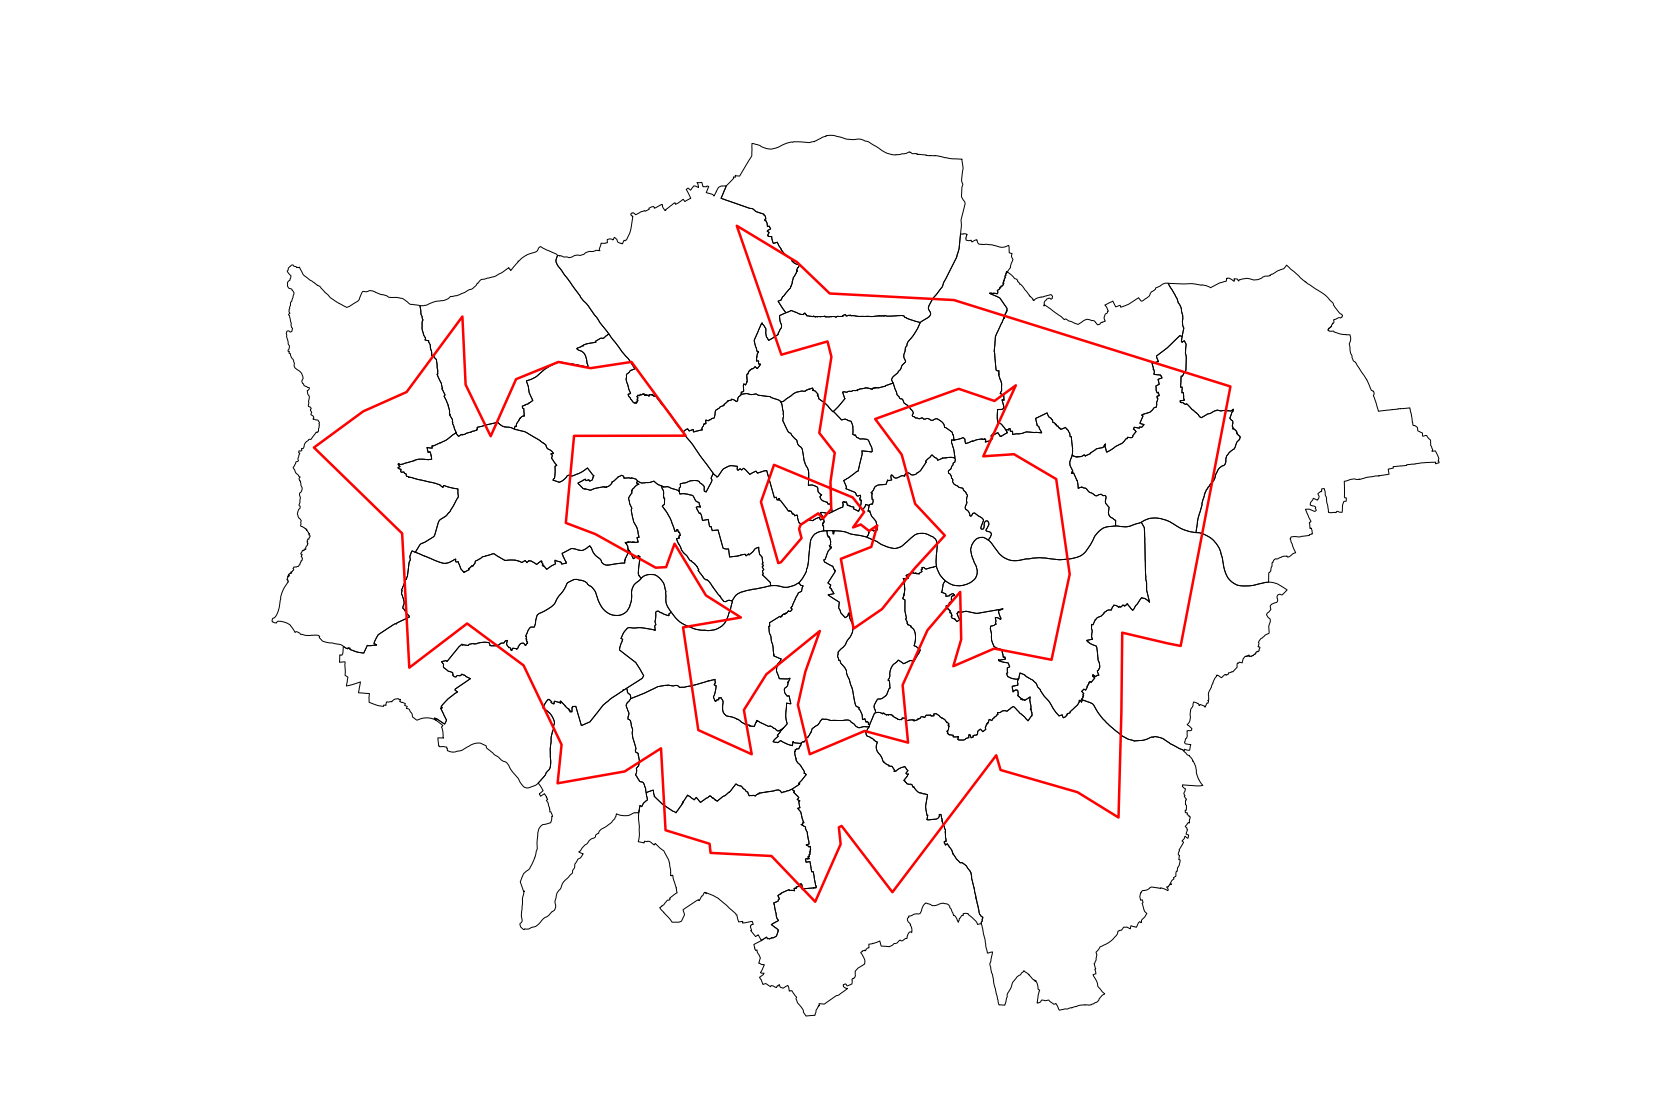

array([ 45,  31,  43,  47,  49,  48,  41,  42,  25, 102, 101, 103, 104,
        82,  84,  83,  50,  51,  26,  27,  30,  29,  28,  15,  56,  57,
        68,  61,  62,  19,  14,  24,  46,  16,  17,  18,  20,  23,  22,
        63,  70,  59,  69,  60,  58,  67,  66,  65,  64,  79,  78,  85,
        88,  76,  80,   8,  81,  77,  75,  87,  96,  99, 100,  97,  98,
        37,  52,  53,  54,  33,  32,  94,  36,  35,  34,  92,  95,  93,
        90,  91,  89,  38,  40,  39,  86,  73,  72,  71,  74,   9,   4,
         6,   5,   7,   1,   0,   2,   3,  10,  11,  13,  12,  55,  21,
        44], dtype=int64)

In [20]:
plot_solution(solution_dict[len(solution_array)-1][0], london_boroughs_gdf, spoons_location_london_df)
solution_dict[len(solution_array)-1][0]

In [ ]:
a = [ 45,  31,  43,  47,  49,  48,  41,  42,  25, 102, 101, 103, 104,
        82,  84,  83,  50,  51,  26,  27,  30,  29,  28,  15,  56,  57,
        68,  61,  62,  19,  14,  24,  46,  16,  17,  18,  20,  23,  22,
        63,  70,  59,  69,  60,  58,  67,  66,  65,  64,  79,  78,  85,
        88,  76,  80,   8,  81,  77,  75,  87,  96,  99, 100,  97,  98,
        37,  52,  53,  54,  33,  32,  94,  36,  35,  34,  92,  95,  93,
        90,  91,  89,  38,  40,  39,  86,  73,  72,  71,  74,   9,   4,
         6,   5,   7,   1,   0,   2,   3,  10,  11,  13,  12,  55,  21,
        44]